In [1]:
import numpy as np
import pandas as pd
import os, joblib

from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize,StandardScaler, minmax_scale
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')

with open('Results/Official_TopicModel_80k.pkl','rb') as File:
    models = joblib.load(File)
    
mapper = models['mapper']
mapper = mapper.loc[-mapper.dynamic_label.isin(['procedural','tribute','NA','armenian_genocide'])]

In [3]:
def make_adj(mat):
    mat_cols = mat.shape[1]
    adj = np.zeros([mat_cols,mat_cols])
    for i in range(mat_cols):
        for ii in range(mat_cols):
            if i != ii:
                adj[i,ii] = 1 - cosine(mat[:,i],mat[:,ii])
            else:
                adj[i,ii] = 1
    return adj
    

### Legislator speech prob

In [37]:
def run_count(year,percentile=90):
    sub_df = all_df.loc[all_df.year == year]
    sub_parties = sub_df[['unique_ID','party']].groupby('unique_ID').first()

    speaker_counts = (sub_df
                      .groupby(['unique_ID','topic_id'])
                      .speaker.count()
                      .reset_index()
                      .pivot(index='unique_ID',columns='topic_id',values='speaker')
                      .fillna(0)
                      .reset_index()
                      .merge(sub_parties,on='unique_ID',how='left')
                     )
    
    Dem_matrix = speaker_counts.loc[speaker_counts.party == 'D'].drop(['unique_ID','party'],1).to_numpy()
    Rep_matrix = speaker_counts.loc[speaker_counts.party == 'R'].drop(['unique_ID','party'],1).to_numpy()
    
    Dem_u = Dem_matrix.mean(axis=0)
    D_sub = Dem_matrix - Dem_u[None,:]
    dem_adj = make_adj(Dem_matrix)

    Rep_u = Rep_matrix.mean(axis=0)
    R_sub = Rep_matrix - Rep_u[None,:]
    rep_adj = make_adj(Rep_matrix)

    upper_D = dem_adj[np.triu_indices_from(dem_adj,1)]
    upper_R = rep_adj[np.triu_indices_from(rep_adj,1)]
    
    return {"year":year,'distance':cosine(upper_D,upper_R),'d_adj':dem_adj,'r_adj':rep_adj}

<AxesSubplot:xlabel='year'>

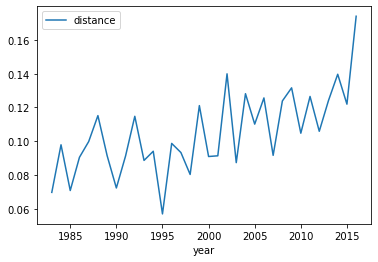

In [38]:
Frame = []
for year in range(1983,2017):
    Frame.append(run_count(year,percentile=0))
pd.DataFrame(Frame).plot(x='year',y='distance')

## Topic Prob 

In [30]:
def run_W(year):
    sub_df = all_df.loc[all_df.year == year]
    dem_mask = np.array([True if I == 'D' else False for I in sub_df.party])
    
    W = [model['W'] for model in models['window_models'] if model['year'] == int(year)][0]
    
    DW = W[dem_mask,:]
    RW = W[~dem_mask,:]
    
    dem_adj = make_adj(DW)
    rep_adj = make_adj(RW)
    
    upper_D = dem_adj[np.triu_indices_from(dem_adj,1)]
    upper_R = rep_adj[np.triu_indices_from(rep_adj,1)]
    
    return {"year":year,'distance':cosine(upper_D,upper_R),'d_adj':dem_adj,'r_adj':rep_adj}

<AxesSubplot:xlabel='year'>

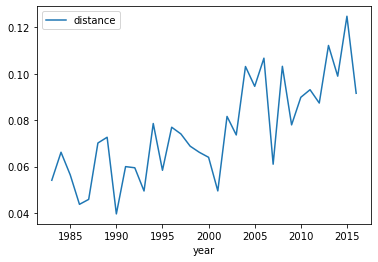

In [31]:
Frame = []
for year in range(1983,2017):
    Frame.append(run_W(year))
pd.DataFrame(Frame).plot(x='year',y='distance')